In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.preprocessing import LabelEncoder

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn import preprocessing

#import k-nearest neighbors for classification
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!pip install python-Levenshtein==0.12.0
#!conda install -c conda-forge geopy --yes
#from 'python-Levenshtein' import distance
#!conda install -c conda-forge lxml --yes
%matplotlib inline

print('Libraries imported.')


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    scipy-1.3.2                |   py36h921218d_0        18.0 MB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge


## Reading the relevant data about venues from the Foursquare API

In [2]:
#Geocoordinates of Chicago
latitude_CH = 41.8686
longitude_CH = -87.6411

In [3]:
CLIENT_ID = 'W4FWDOZARKBV1SZXM1M2AJAFLODJANP4XTV121T5ASZ5WQ25' # your Foursquare ID
CLIENT_SECRET = 'KU150VOJ0ZSSGCLPCF4M05ATJQ4TJJQAIWVXLWBHS42L5ZPR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 10000
limit = 15000

In [4]:
url_explore = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_CH, longitude_CH, VERSION, radius, limit)
results = requests.get(url_explore).json()
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

In [5]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [6]:
# function that reads number of likes for the venue
def get_likes_for_venue(row, CLIENT_ID, CLIENT_SECRET, Version):
    venueId = row['venue.id']
    url_venue = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId,CLIENT_ID,CLIENT_SECRET,Version)
    likes = result['response']['venue']['likes']['count']
    return likes

# function that reads rating for the venue
def get_rating_for_venue(row, CLIENT_ID, CLIENT_SECRET, Version):
    venueId = row['venue.id']
    url_venue = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId,CLIENT_ID,CLIENT_SECRET,Version)
    result = requests.get(url_venue).json()
    rating = result['response']['venue']['rating']
    return rating

# function that reads likes and rating for the venue
def get_likes_rating_for_venue(row, CLIENT_ID, CLIENT_SECRET, Version):
    venueId = row['venue.id']
    url_venue = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId,CLIENT_ID,CLIENT_SECRET,Version)
    result = requests.get(url_venue).json()
    likes = result['response']['venue']['likes']['count']
    rating = result['response']['venue']['rating']
    return [venueId,likes,rating]

In [7]:
df_likes_ratings_CH = pd.read_csv('chicago_venues_likes_ratings.csv', delimiter=',',usecols=[1, 2, 3])
df_likes_ratings_CH.head()

,venue.id,venue.likes,venue.rating
0,4abaf75bf964a520768320e3,346,6
1,49bac1c8f964a520a0531fe3,362,2
2,4bbfae5eb492d13ad218a360,195,8
3,4b15b142f964a520a3b223e3,401,2
4,4b699582f964a52061a82be3,311,2


In [8]:
nearby_venues = nearby_venues.merge(df_likes_ratings_CH, on='venue.id')

In [9]:
#nearby_venues['venue.likes'] = nearby_venues.apply(get_likes_for_venue, args=(CLIENT_ID,CLIENT_SECRET,VERSION), axis=1)
#nearby_venues['venue.rating'] = nearby_venues.apply(get_rating_for_venue, args=(CLIENT_ID,CLIENT_SECRET,VERSION), axis=1)
# filter columns
filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.address', 'venue.location.lat', 'venue.location.lng', 'venue.likes', 'venue.rating']
nearby_venues = nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_restaurants = nearby_venues[:]#[nearby_venues['venue.categories'].str.contains('Restaurant')]
# clean columns
nearby_restaurants.columns = [col.split(".")[-1] for col in nearby_restaurants.columns]
nearby_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 8 columns):
id            100 non-null object
name          100 non-null object
categories    100 non-null object
address       100 non-null object
lat           100 non-null float64
lng           100 non-null float64
likes         100 non-null int64
rating        100 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.0+ KB


In [10]:
#Drop records without address because matching must include the address
nearby_restaurants.dropna(subset=['address'], inplace=True)
nearby_restaurants.head()

,id,name,categories,address,lat,lng,likes,rating
0,4abaf75bf964a520768320e3,Binny's Beverage Depot,Liquor Store,1132 S Jefferson St,41.867970,-87.642724,346,6
1,49bac1c8f964a520a0531fe3,Manny's Cafeteria & Delicatessen,Sandwich Place,1141 S Jefferson St,41.867931,-87.641991,362,2
2,4bbfae5eb492d13ad218a360,Ping Tom Memorial Park,Park,300 W 19th St,41.859120,-87.632577,195,8
3,4b15b142f964a520a3b223e3,Kriser's Natural Pet,Pet Service,1103 S. State St.,41.869137,-87.627229,401,2
4,4b699582f964a52061a82be3,Jazz Showcase,Jazz Club,806 S Plymouth Ct,41.871650,-87.628707,311,2


In [11]:
nearby_restaurants.describe()

,lat,lng,likes,rating
count,100.000000,100.000000,100.000000,100.000000
mean,41.882749,-87.635946,282.860000,4.690000
std,0.009615,0.014028,120.671607,2.784136
min,41.849700,-87.674244,103.000000,0.000000
25%,41.880969,-87.648632,168.500000,2.000000
50%,41.884529,-87.631123,274.500000,4.500000
75%,41.889344,-87.624936,372.250000,7.000000
max,41.895807,-87.608781,499.000000,9.000000


## Reading the data about inspections

In [12]:
#Read out results of the inspection controls for Chicago
insp_results = pd.read_csv('Food_Inspections.csv', delimiter=',')
insp_results_rest = insp_results#[insp_results['Facility Type'] == 'Restaurant']
columns_of_interest = ['DBA Name', 'Facility Type', 'Inspection Date', 'Address', 'City', 'State', 'Zip', 'Latitude', 'Longitude','Risk']
insp_results_rest = insp_results_rest[columns_of_interest]
insp_results_rest.describe()

,Zip,Latitude,Longitude
count,195031.000000,194398.000000,194398.000000
mean,60628.738713,41.881308,-87.676878
std,122.454785,0.080809,0.058933
min,10014.000000,41.644670,-87.914428
25%,60614.000000,41.835336,-87.707795
50%,60625.000000,41.891987,-87.666847
75%,60643.000000,41.939827,-87.635041
max,60827.000000,42.021064,-87.525094


## Data visualisation

Text(0.5, 1.0, 'Distribution of number of likes for venues dataset')

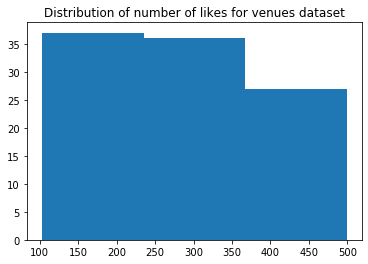

In [13]:
#Visualize distribution of likes in Foursquare dataset
plt.hist(nearby_restaurants['likes'], bins=3)
plt.title('Distribution of number of likes for venues dataset')

([<matplotlib.axis.XTick at 0x7f1520779cc0>,
 <a list of 10 Text xticklabel objects>)

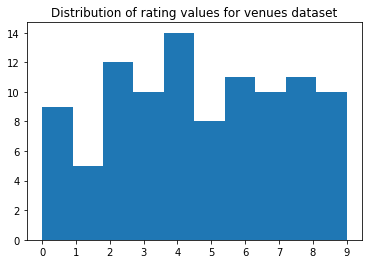

In [14]:
#Visualize distribution of rating in Foursquare dataset
plt.hist(nearby_restaurants['rating'], bins=10)
plt.title('Distribution of rating values for venues dataset')
plt.xticks(np.arange(0, 10, step=1))

## Data insight and wrangling

In [15]:
#Check dirty data in column City
insp_results_rest['City'].value_counts(dropna=False)

CHICAGO         194243
Chicago            320
NaN                138
chicago             97
CCHICAGO            46
                 ...  
LANSING              1
BURNHAM              1
alsip                1
NEW HOLSTEIN         1
BROADVIEW            1
Name: City, Length: 72, dtype: int64

In [16]:
#Resolve dirty data in column City
insp_results_rest['City'] = 'CHICAGO'
insp_results_rest['City'].value_counts(dropna=False)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


CHICAGO    195081
Name: City, dtype: int64

In [17]:
#Check missing data in column State
insp_results_rest['State'].value_counts(dropna=False)

IL     195036
NaN        42
IN          1
WI          1
NY          1
Name: State, dtype: int64

In [18]:
#Resolve missing data in column State
insp_results_rest['State'] = 'IL'
insp_results_rest['State'].value_counts(dropna=False)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


IL    195081
Name: State, dtype: int64

In [19]:
#Check missing data in column Zip
insp_results_rest[insp_results_rest['Zip'].isna()].shape[0]

50

In [20]:
#Resolve missing data in column Zip - fill with the most frequent value
insp_results_rest['Zip'].fillna(insp_results_rest['Zip'].value_counts().index[0],inplace=True) 
insp_results_rest[insp_results_rest['Zip'].isna()].shape[0]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


0

In [21]:
#Check missing data in column Latitude
insp_results_rest[insp_results_rest['Latitude'].isna()].shape[0]

683

In [22]:
#Check missing data in column Longitude
insp_results_rest[insp_results_rest['Longitude'].isna()].shape[0]

683

In [23]:
#Delete rows with missing data in columns Latitude and Longitude
insp_results_rest.dropna(subset=['Latitude','Longitude'],inplace=True)
insp_results_rest[insp_results_rest['Longitude'].isna()].shape[0]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0

In [24]:
#Check missing data in column Risk
insp_results_rest['Risk'].value_counts(dropna=False)

Risk 1 (High)      139442
Risk 2 (Medium)     37926
Risk 3 (Low)        16928
NaN                    71
All                    31
Name: Risk, dtype: int64

In [25]:
#Resolving missing data in column Risk - replace with the most frequent value
insp_results_rest['Risk'].fillna(insp_results_rest['Risk'].value_counts().index[0],inplace=True) 
insp_results_rest['Risk'].value_counts(dropna=False)

Risk 1 (High)      139513
Risk 2 (Medium)     37926
Risk 3 (Low)        16928
All                    31
Name: Risk, dtype: int64

In [26]:
#Convert Inspection Date from string to datetime
insp_results_rest['Inspection Date']=pd.to_datetime(insp_results_rest['Inspection Date'],dayfirst=False,yearfirst=False)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
#Take only the results of last inspection
insp_sorted = insp_results_rest.sort_values(by='Inspection Date', ascending=False)
insp_sorted_filtered = insp_sorted.drop_duplicates(subset=['DBA Name','Latitude','Longitude'], keep='first')
insp_sorted_filtered.head(2)

,DBA Name,Facility Type,Inspection Date,Address,City,State,Zip,Latitude,Longitude,Risk
0,SALSA'S GRILL,Restaurant,2019-10-29,3808 W LAWRENCE AVE,CHICAGO,IL,60625.0,41.968399,-87.723551,Risk 1 (High)
28481,OSITO'S TAP,Restaurant,2019-10-29,2553 S RIDGEWAY AVE,CHICAGO,IL,60623.0,41.844597,-87.718313,Risk 1 (High)


In [28]:
insp_sorted_filtered['Risk'].value_counts(dropna=False)

Risk 1 (High)      16740
Risk 3 (Low)        7521
Risk 2 (Medium)     6988
All                   26
Name: Risk, dtype: int64

Text(0.5, 1.0, 'Risk data distribution of filtered data')

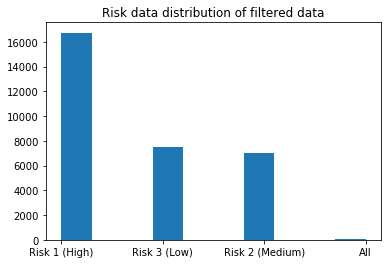

In [29]:
#Visualize risk distribution of the filtered data
plt.hist(insp_sorted_filtered['Risk'])
plt.title('Risk data distribution of filtered data')

In [30]:
le=LabelEncoder()
le.fit(['All','Risk 3 (Low)','Risk 2 (Medium)','Risk 1 (High)'])
insp_sorted_filtered['Risk'] = le.fit_transform(insp_sorted_filtered['Risk'])
insp_sorted_filtered['Risk'].value_counts(dropna=False)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1    16740
3     7521
2     6988
0       26
Name: Risk, dtype: int64

Text(0.5, 1.0, 'Risk data distribution of filtered data')

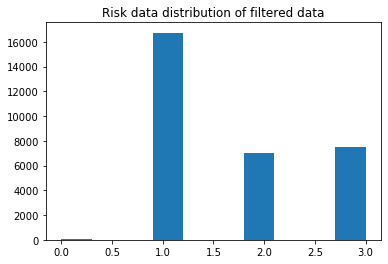

In [31]:
#Visualize the encoded risk data
plt.hist(insp_sorted_filtered['Risk'])
plt.title('Risk data distribution of filtered data')

In [32]:
#Visualizing datasets on the map

print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude_CH, longitude_CH))

# create map of Chicago using latitude and longitude values
map_chicago1 = folium.Map(location=[latitude_CH, longitude_CH], zoom_start=12)

# add markers from the first dataset to map
for lat, lng, name in zip(nearby_restaurants['lat'], nearby_restaurants['lng'], nearby_restaurants['name']):
    label = name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago1)  
    
map_chicago1

The geograpical coordinate of Chicago are 41.8686, -87.6411.


### Matching the data from Foursquare and inspection dataset for training data

In [33]:
#Function which calculates the Levenshtein's distance of two strings
from Levenshtein import distance as pl_dist
def column_lev_dist(arr,val):
    out = np.zeros(arr.shape[0])
    for i in range(0,arr.shape[0]):
        out[i] = pl_dist(str(arr.iloc[i]).upper(),str(val).upper())
    return out

In [34]:
#Definition of the complex measure of matching between two datasets = Levenshtein's distance of the name and address
def check_matching_levenshtein(df1,df2,col11,col12,col21,col22,threshold1,threshold2):
    df_out = pd.DataFrame(columns=df2.columns.values)
    df2['key']=1
    df1['key']=1
    num_matches = 0
    for i in range(0,df1.shape[0]):
        idx1=column_lev_dist(df2[col12],df1.iloc[i][col11])<threshold1 
        idx2=column_lev_dist(df2[col22],df1.iloc[i][col21])<threshold2
        idx=np.logical_and(idx1,idx2)
        df_match=df2[idx]
        df_match = pd.merge(df_match,df1.loc[[i]],on='key')
        del df_match['key']
        num_matches += df_match.shape[0]
        df_out = pd.concat([df_out, df_match], ignore_index=True, sort=False)
    return [num_matches, df_out]

In [35]:
data1 = check_matching_levenshtein(nearby_restaurants,insp_sorted_filtered,'name','DBA Name','address','Address',5,8)
print('Num_matches:', data1[0])
ds_restaurants_classification = data1[1]
data1[1].head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Num_matches: 82


,DBA Name,Facility Type,Inspection Date,Address,City,State,Zip,Latitude,Longitude,Risk,id,name,categories,address,lat,lng,likes,rating
0,MARIANO'S,Grocery Store,2019-06-13,1615 S CLARK ST,CHICAGO,IL,60616.0,41.859630,-87.630125,1,52504b1e11d244cf89f21d1f,Mariano's,Grocery Store,1615 S Clark St,41.859330,-87.629622,499.0,9.0
1,NINO'S,Restaurant,2019-03-13,115 S CLINTON ST,CHICAGO,IL,60661.0,41.880084,-87.640991,1,52504b1e11d244cf89f21d1f,Mariano's,Grocery Store,1615 S Clark St,41.859330,-87.629622,499.0,9.0
2,Frank's,TAVERN,2018-04-26,2503 N CLARK ST,CHICAGO,IL,60614.0,41.927947,-87.641726,3,52504b1e11d244cf89f21d1f,Mariano's,Grocery Store,1615 S Clark St,41.859330,-87.629622,499.0,9.0
3,LIAN'S,Grocery Store,2014-11-28,6507 N CLARK ST,CHICAGO,IL,60626.0,42.000153,-87.671154,3,52504b1e11d244cf89f21d1f,Mariano's,Grocery Store,1615 S Clark St,41.859330,-87.629622,499.0,9.0
4,AUDITORIUM THEATRE,theater,2011-08-26,50 E CONGRESS PKWY,CHICAGO,IL,60605.0,41.875803,-87.625734,3,4ae786a5f964a52019ac21e3,Auditorium Theatre,Theater,50 E Congress Pkwy,41.876058,-87.625303,207.0,3.0


In [36]:
# create map of Chicago using latitude and longitude values
map_chicago2 = folium.Map(location=[latitude_CH, longitude_CH], zoom_start=12)
#x = np.arange(4)
#ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = ['red','cyan','magenta','blue']
#rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers from the second dataset to map
for lat, lng, name, risk in zip(ds_restaurants_classification['Latitude'], ds_restaurants_classification['Longitude'], ds_restaurants_classification['DBA Name'], ds_restaurants_classification['Risk']):
    label = 'Name:{}, risk:{}'.format(name, risk)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors_array[risk],
        fill=True,
        fill_color=colors_array[risk],
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago2)  

map_chicago2

In [37]:
ds_restaurants_classification.describe()

,Zip,Latitude,Longitude,lat,lng,likes,rating
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,60619.817073,41.883804,-87.637147,41.883342,-87.641713,251.841463,5.951220
std,20.040162,0.032306,0.014064,0.010695,0.012622,129.944382,2.542976
min,60601.000000,41.736380,-87.674283,41.849700,-87.674244,103.000000,0.000000
25%,60607.000000,41.884180,-87.648251,41.882982,-87.649086,132.500000,4.000000
50%,60611.000000,41.886157,-87.634847,41.885761,-87.643467,240.000000,7.000000
75%,60642.000000,41.891620,-87.625823,41.891133,-87.629655,341.250000,8.000000
max,60661.000000,42.000153,-87.609518,41.895807,-87.617027,499.000000,9.000000


## Preparing the training data sets for classifier

In [38]:
x_train = ds_restaurants_classification[['likes','rating']]
y_train = ds_restaurants_classification['Risk'].values

Text(0.5, 1.0, 'Relation between number of likes and encoded value of risk')

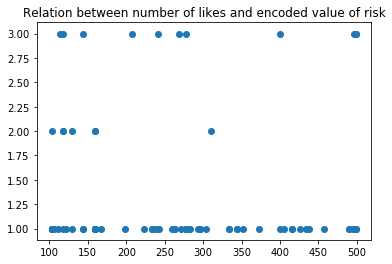

In [39]:
plt.scatter(x_train['likes'],y_train)
plt.title('Relation between number of likes and encoded value of risk')

([<matplotlib.axis.XTick at 0x7f152047e4a8>,
 <a list of 10 Text xticklabel objects>)

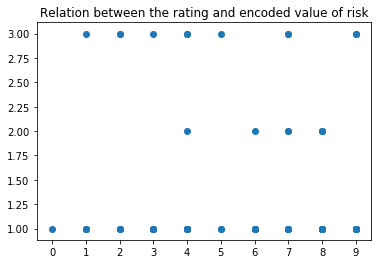

In [40]:
plt.scatter(x_train['rating'],y_train)
plt.title('Relation between the rating and encoded value of risk')
plt.xticks(np.arange(0,10,step=1))

In [41]:
y_train = y_train.astype(float)

In [42]:
#KNN classification
k = 4
x_train_scaled=preprocessing.StandardScaler().fit(x_train).transform(x_train.astype(float))
#Train Model  
neigh = KNeighborsClassifier(n_neighbors = k)
neigh.fit(x_train_scaled,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [43]:
#Decision trees classification
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
#Logistic regression classification
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='newton-cg', multi_class='multinomial')
LR.fit(x_train_scaled,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

## Preparing the data for San Francisco as test data

In [45]:
#Geocoordinates of San Francisco
latitude_SF = 37.7576793
longitude_SF = -122.5076403

In [46]:
#Get venues from Foursquare for San Francisco
url_explore = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_SF, longitude_SF, VERSION, radius, limit)
results = requests.get(url_explore).json()
venues = results['response']['groups'][0]['items']
nearby_venues_SF = json_normalize(venues) # flatten JSON

In [47]:
#Read already in csv file saved data about likes and ratings for dataset and join with metadata dataset
df_likes_ratings_SF = pd.read_csv('sanfrancisco_venues_likes_ratings.csv', delimiter=',',usecols=[1, 2, 3])
df_likes_ratings_SF.head()

,venue.id,venue.likes,venue.rating
0,4a7cfa96f964a52036ee1fe3,60,9.3
1,5107fc22b0ed34df491330a9,538,9.2
2,55876ba3498e08016ede6a73,152,9.2
3,4db0bc8e0437a93f7f7a23e7,437,9.2
4,409ad180f964a520eef21ee3,1947,9.3


In [48]:
#Merge datasets
nearby_venues_SF = nearby_venues_SF.merge(df_likes_ratings_SF, on='venue.id')

In [49]:
#nearby_venues['venue.likes'] = nearby_venues.apply(get_likes_for_venue, args=(CLIENT_ID,CLIENT_SECRET,VERSION), axis=1)
#nearby_venues['venue.rating'] = nearby_venues.apply(get_rating_for_venue, args=(CLIENT_ID,CLIENT_SECRET,VERSION), axis=1)
# filter columns
filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.address', 'venue.location.lat', 'venue.location.lng', 'venue.likes', 'venue.rating']
nearby_venues_SF = nearby_venues_SF.loc[:, filtered_columns]
# filter the category for each row
nearby_venues_SF['venue.categories'] = nearby_venues_SF.apply(get_category_type, axis=1)
nearby_restaurants_SF = nearby_venues_SF[:]#[nearby_venues['venue.categories'].str.contains('Restaurant')]
# clean columns
nearby_restaurants_SF.columns = [col.split(".")[-1] for col in nearby_restaurants_SF.columns]
nearby_restaurants_SF.head(2)

,id,name,categories,address,lat,lng,likes,rating
0,4a7cfa96f964a52036ee1fe3,Mollusk Surf Shop,Board Shop,4500 Irving St,37.762395,-122.506185,60,9.3
1,5107fc22b0ed34df491330a9,Andytown,Coffee Shop,3655 Lawton St,37.756788,-122.502307,538,9.2


In [145]:
nearby_restaurants_SF.describe()

,lat,lng,likes,rating,risk_predicted,key
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,37.772129,-122.461477,476.980000,9.258000,2.260000,1.0
std,0.019293,0.025671,704.418321,0.139393,0.970473,0.0
min,37.709594,-122.512851,23.000000,9.100000,1.000000,1.0
25%,37.763312,-122.478118,86.500000,9.100000,1.000000,1.0
50%,37.770993,-122.457065,207.000000,9.200000,3.000000,1.0
75%,37.783836,-122.437929,538.000000,9.300000,3.000000,1.0
max,37.810449,-122.426825,3919.000000,9.600000,3.000000,1.0


Text(0.5, 1.0, 'Distribution of number of likes for venues dataset')

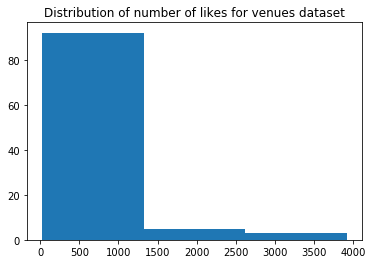

In [141]:
#Visualize distribution of likes in Foursquare dataset
plt.hist(nearby_restaurants_SF['likes'], bins=3)
plt.title('Distribution of number of likes for venues dataset')

([<matplotlib.axis.XTick at 0x7f14f3b6dba8>,
 <a list of 10 Text xticklabel objects>)

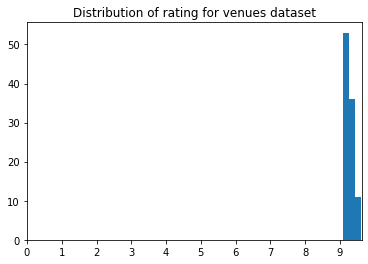

In [144]:
#Visualize distribution of rating in Foursquare dataset
plt.hist(nearby_restaurants_SF['rating'], bins=3)
plt.title('Distribution of rating for venues dataset')
plt.xticks(np.arange(0,10,step=1))

In [148]:
#Visualizing the test data from Foursquare
# create map of SF using latitude and longitude values
map_san_francisco = folium.Map(location=[latitude_SF, longitude_SF], zoom_start=13)
# add markers from the second dataset to map
for lat, lng, name in zip(nearby_restaurants_SF['lat'], nearby_restaurants_SF['lng'], nearby_restaurants_SF['name']):
    label = 'Name:{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_san_francisco)  

map_san_francisco

In [50]:
x_test = nearby_restaurants_SF[['likes','rating']]
x_test_scaled=preprocessing.StandardScaler().fit(x_test).transform(x_test.astype(float))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [155]:
#KNN prediction
y_test = neigh.predict(x_test_scaled)
#nearby_restaurants_SF['risk_predicted'] = y_test

#nearby_restaurants_SF['risk_predicted'].value_counts()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [180]:
#dtree prediction
y_test_2 = dtree.predict(x_test)
nearby_restaurants_SF['risk_predicted']=y_test_2
#nearby_restaurants_SF['risk_predicted'].value_counts()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [181]:
#Logistic regression prediction
y_test_3 = LR.predict(x_test)
#nearby_restaurants_SF['risk_predicted'] = y_test_3
#nearby_restaurants_SF['risk_predicted'].value_counts()

## Dataset of inspection controls for San Francisco

In [182]:
#Read results of the inspection controls for San Francisco out
insp_results_rest_SF = pd.read_csv('Restaurant_Scores_SF.csv', delimiter=',')
insp_results_rest_SF.head()

,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,business_phone_number,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category
0,69618,Fancy Wheatfield Bakery,1362 Stockton St,San Francisco,CA,94133,NaN,NaN,NaN,NaN,69618_20190304,03/04/2019 12:00:00 AM,NaN,Complaint,69618_20190304_103130,Inadequate sewage or wastewater disposal,Moderate Risk
1,97975,BREADBELLY,1408 Clement St,San Francisco,CA,94118,NaN,NaN,NaN,1.415724e+10,97975_20190725,07/25/2019 12:00:00 AM,96.0,Routine - Unscheduled,97975_20190725_103124,Inadequately cleaned or sanitized food contact...,Moderate Risk
2,69487,Hakkasan San Francisco,1 Kearny St,San Francisco,CA,94108,NaN,NaN,NaN,NaN,69487_20180418,04/18/2018 12:00:00 AM,88.0,Routine - Unscheduled,69487_20180418_103119,Inadequate and inaccessible handwashing facili...,Moderate Risk
3,91044,Chopsticks Restaurant,4615 Mission St,San Francisco,CA,94112,NaN,NaN,NaN,NaN,91044_20170818,08/18/2017 12:00:00 AM,NaN,Non-inspection site visit,NaN,NaN,NaN
4,85987,Tselogs,552 Jones St,San Francisco,CA,94102,NaN,NaN,NaN,NaN,85987_20180412,04/12/2018 12:00:00 AM,94.0,Routine - Unscheduled,85987_20180412_103132,Improper thawing methods,Moderate Risk


### Data wrangling

In [183]:
insp_results_rest_SF['risk_category'].value_counts(dropna=False)

Low Risk         19112
Moderate Risk    15316
NaN              13720
High Risk         5825
Name: risk_category, dtype: int64

In [184]:
#Delete NaN records
insp_results_rest_SF.dropna(subset=['risk_category'],inplace=True)
insp_results_rest_SF['risk_category'].value_counts(dropna=False)

Low Risk         19112
Moderate Risk    15316
High Risk         5825
Name: risk_category, dtype: int64

In [185]:
columns_of_interest = ['business_name', 'inspection_date', 'business_address', 'business_city', 'business_state', 'business_postal_code', 'risk_category']
insp_results_rest_SF = insp_results_rest_SF[columns_of_interest]

In [186]:
insp_results_rest_SF.head()

,business_name,inspection_date,business_address,business_city,business_state,business_postal_code,risk_category
0,Fancy Wheatfield Bakery,03/04/2019 12:00:00 AM,1362 Stockton St,San Francisco,CA,94133,Moderate Risk
1,BREADBELLY,07/25/2019 12:00:00 AM,1408 Clement St,San Francisco,CA,94118,Moderate Risk
2,Hakkasan San Francisco,04/18/2018 12:00:00 AM,1 Kearny St,San Francisco,CA,94108,Moderate Risk
4,Tselogs,04/12/2018 12:00:00 AM,552 Jones St,San Francisco,CA,94102,Moderate Risk
8,"The Estate Kitchen, LLC",04/16/2018 12:00:00 AM,799 Bryant St,San Francisco,CA,94107,Low Risk


In [187]:
#Take only the results of last inspection
insp_sorted_SF = insp_results_rest_SF.sort_values(by='inspection_date', ascending=False)
insp_sorted_filtered_SF = insp_sorted_SF.drop_duplicates(subset=['business_name','business_address'], keep='first')
insp_sorted_filtered_SF.reset_index(inplace=True)
insp_sorted_filtered_SF.head(2)

,index,business_name,inspection_date,business_address,business_city,business_state,business_postal_code,risk_category
0,29607,Pedrito's,12/30/2016 12:00:00 AM,3254 23rd St,San Francisco,CA,94110,Low Risk
1,35810,Cocobang,12/30/2016 12:00:00 AM,550 Taylor St,San Francisco,CA,94102,Moderate Risk


In [188]:
insp_sorted_filtered_SF['risk_category'].value_counts(dropna=False)

Low Risk         2482
Moderate Risk    2225
High Risk         726
Name: risk_category, dtype: int64

Text(0.5, 1.0, 'Distribution of risk data in test dataset')

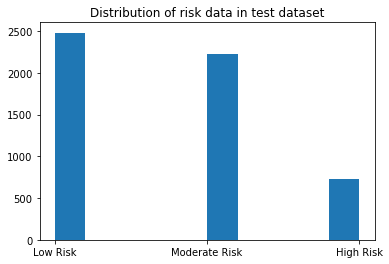

In [189]:
plt.hist(insp_sorted_filtered_SF['risk_category'])
plt.title('Distribution of risk data in test dataset')

In [190]:
#Encode the risk_category column
insp_sorted_filtered_SF.replace({'risk_category':'Low Risk'},3, inplace=True)
insp_sorted_filtered_SF.replace({'risk_category':'Moderate Risk'},2, inplace=True)
insp_sorted_filtered_SF.replace({'risk_category':'High Risk'},1, inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [191]:
insp_sorted_filtered_SF.head()

,index,business_name,inspection_date,business_address,business_city,business_state,business_postal_code,risk_category
0,29607,Pedrito's,12/30/2016 12:00:00 AM,3254 23rd St,San Francisco,CA,94110,3
1,35810,Cocobang,12/30/2016 12:00:00 AM,550 Taylor St,San Francisco,CA,94102,2
2,42739,Jones,12/30/2016 12:00:00 AM,620 Jones St,San Francisco,CA,94102,3
3,36113,LUCKY PORK MARKET,12/30/2016 12:00:00 AM,2659 MISSION St,San Francisco,CA,94110,3
4,39228,Grand Coffee,12/30/2016 12:00:00 AM,2663 Mission St,San Francisco,CA,94110,3


## Matching the Foursquare and inspection datasets for test data

In [192]:
#Finding the matching rows using Levenshtein's string distance
data2 = check_matching_levenshtein(nearby_restaurants_SF,insp_sorted_filtered_SF,'name','business_name','address','business_address',5,8)
num_matches = data2[0]
results = data2[1]
print('Num_matches:',num_matches)
results.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Num_matches: 56


,index,business_name,inspection_date,business_address,business_city,business_state,business_postal_code,risk_category,id,name,categories,address,lat,lng,likes,rating,risk_predicted
0,13943,Yuanbao Jiaozi,05/22/2019 12:00:00 AM,2110 Irving St,San Francisco,CA,94122,2,5a80ea27c58ed77c7cbcd80c,Yuanbao Jiaozi,Dumpling Restaurant,2110 Irving St,37.763494,-122.480616,98.0,9.3,1.0
1,23825,House of Pancakes,12/05/2016 12:00:00 AM,937 TARAVAL,San Francisco,CA,94116,2,512831dae4b058a839d3cdac,House of Pancakes,Chinese Restaurant,937 Taraval St,37.742856,-122.476184,186.0,9.1,1.0
2,15259,Pizzetta 211,07/22/2019 12:00:00 AM,211 23rd Ave,San Francisco,CA,94121,3,40df5f80f964a52096011fe3,Pizzetta 211,Pizza Place,211 23rd Ave,37.783694,-122.482879,270.0,9.1,1.0
3,41039,Halu,12/05/2017 12:00:00 AM,312 08th Ave,San Francisco,CA,94118,2,3fd66200f964a52017ed1ee3,Ebisu,Sushi Restaurant,1283 9th Ave,37.764354,-122.466358,263.0,9.1,1.0
4,47943,Umi,10/12/2017 12:00:00 AM,1328 18th St,San Francisco,CA,94107,1,3fd66200f964a52017ed1ee3,Ebisu,Sushi Restaurant,1283 9th Ave,37.764354,-122.466358,263.0,9.1,1.0


In [193]:
#Visualizing the merged test data
# create map of SF using latitude and longitude values
map_san_francisco = folium.Map(location=[latitude_SF, longitude_SF], zoom_start=13)
colors_array = ['red','cyan','magenta','blue']
# add markers from the second dataset to map
for lat, lng, name, risk in zip(results['lat'], results['lng'], results['business_name'], results['risk_category'].astype(int)):
    label = 'Name:{}, risk:{}'.format(name, risk)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors_array[risk],
        fill=True,
        fill_color=colors_array[risk],
        fill_opacity=0.7,
        parse_html=False).add_to(map_san_francisco)  

map_san_francisco

In [194]:
#Count of reference values
results['risk_category'].value_counts()

3    26
2    26
1     4
Name: risk_category, dtype: int64

In [195]:
#Count of predicted values
results['risk_predicted'].value_counts()

1.0    55
2.0     1
Name: risk_predicted, dtype: int64

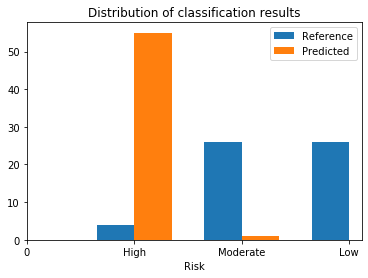

In [196]:
#Comparison of distribution of classifier's results
width=0.35
labels=['0', 'High','Moderate','Low']
fig, ax = plt.subplots()
rects1 = ax.bar(results['risk_category'].value_counts().index - width/2, results['risk_category'].value_counts(), width, label='Reference')
rects2 = ax.bar(results['risk_predicted'].value_counts().index + width/2, results['risk_predicted'].value_counts(), width, label='Predicted')
ax.set_title('Distribution of classification results')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Risk')
ax.legend()
plt.show()

In [197]:
#Classification error
y_ref = results['risk_category'].astype(float)
y_hat = results['risk_predicted'].astype(float)

In [198]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_ref, y_hat)

0.07142857142857142

In [199]:
from sklearn.metrics import f1_score
f1_score(y_ref, y_hat, average='weighted') 

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.009685230024213076

### Visualizing the results of classification

In [200]:
#Visualizing the results of classification with coloring
# create map of SF using latitude and longitude values
map_san_francisco = folium.Map(location=[latitude_SF, longitude_SF], zoom_start=13)
colors_array = ['red','cyan','magenta','blue']
# add markers from the second dataset to map
for lat, lng, name, risk in zip(results['lat'], results['lng'], results['business_name'], results['risk_predicted'].astype(int)):
    label = 'Name:{}, risk:{}'.format(name, risk)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors_array[risk],
        fill=True,
        fill_color=colors_array[risk],
        fill_opacity=0.7,
        parse_html=False).add_to(map_san_francisco)  

map_san_francisco

In [201]:
#Find hits
idx=results['risk_category'].astype(float)==results['risk_predicted'].astype(float)
hits = results[idx]

In [202]:
#Visualize hits on the map
# create map of SF using latitude and longitude values
map_san_francisco = folium.Map(location=[latitude_SF, longitude_SF], zoom_start=13)
# add markers from the second dataset to map
for lat, lng, name, risk in zip(hits['lat'], hits['lng'], hits['business_name'], le.inverse_transform(hits['risk_predicted'].astype(int))):
    label = 'Name:{}, risk:{}'.format(name, risk)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_san_francisco)  

map_san_francisco

In [203]:
#Visualize hits and fails on the same map
# create map of SF using latitude and longitude values
map_san_francisco = folium.Map(location=[latitude_SF, longitude_SF], zoom_start=13)
# add markers from the second dataset to map
for lat, lng, name, risk_cat, risk_pred in zip(results['lat'], results['lng'], results['business_name'], results['risk_category'], results['risk_predicted']):
    label = 'Name:{}, risk real:{}, risk predicted:{}'.format(name, risk_cat, risk_pred)
    label = folium.Popup(label, parse_html=True)
    if(float(risk_cat)==float(risk_pred)):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            parse_html=False).add_to(map_san_francisco)
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            parse_html=False).add_to(map_san_francisco)
            
map_san_francisco